In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg19

result_prefix = "generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
content_path = 'C:/brain_tumor/version2/notebook/try_img/image_10.png'
style_path = 'C:/brain_tumor/version2/classify_dataset/glioma/gli (73).jpg'
# Dimensions of the generated picture.
# width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 256
img_ncols = 256

Source Image


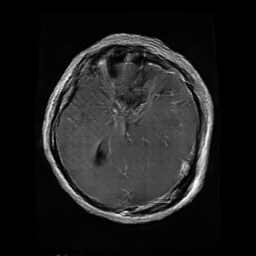

In [3]:
from IPython.display import Image, display

print("Source Image")
display(Image(content_path))

Style Image


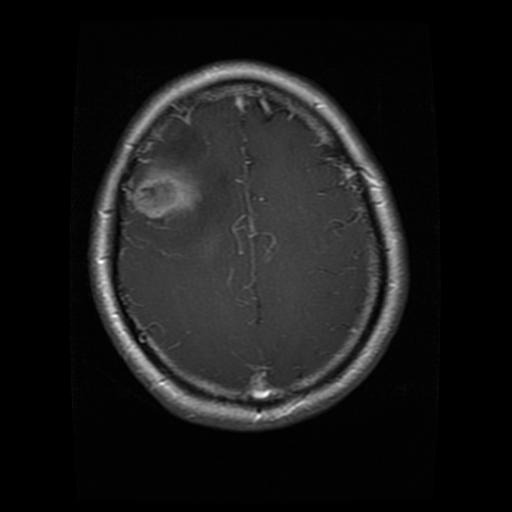

In [4]:
print("Style Image")
display(Image(style_path))

In [3]:

def preprocess_image(image_path):
    # Util function to open, resize and format 
    # pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [4]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    a = tf.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :]
    )
    b = tf.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [5]:
# HIDE OUTPUT
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [6]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [7]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [8]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)
combination_image = tf.Variable(preprocess_image(content_path))

iterations = 5
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 1 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(f'C:/brain_tumor/version2/notebook/style_trans_img/{fname}', img)

Iteration 1: loss=2127487616.00
Iteration 2: loss=inf
Iteration 3: loss=inf
Iteration 4: loss=nan
Iteration 5: loss=nan


C:\Users\admin\AppData\Local\Temp\ipykernel_17196\4196725163.py:22: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype("uint8")


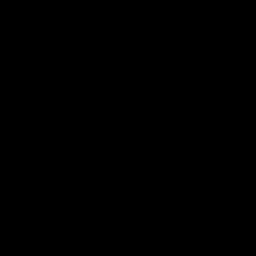

In [11]:
display(Image(f'C:/brain_tumor/version2/notebook/style_trans_img/{result_prefix}_at_iteration_5.png'))

total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg19

result_prefix = "generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
content_path = 'C:/brain_tumor/version2/notebook/try_img/image_10.png'
style_path = 'C:/brain_tumor/version2/classify_dataset/glioma/gli (152).jpg'
# Dimensions of the generated picture.
# width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 256
img_ncols = 256


def preprocess_image(image_path):
    # Util function to open, resize and format 
    # pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    a = tf.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :]
    )
    b = tf.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# HIDE OUTPUT
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=50.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)
combination_image = tf.Variable(preprocess_image(content_path))

iterations = 1000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(f'C:/brain_tumor/version2/notebook/style_trans_img/{fname}', img)

Iteration 100: loss=1930.91
Iteration 200: loss=952.22
Iteration 300: loss=581.03
Iteration 400: loss=707.33
Iteration 500: loss=892.64
Iteration 600: loss=977.78
Iteration 700: loss=747.00
Iteration 800: loss=493.77
Iteration 900: loss=411.72
Iteration 1000: loss=389.04


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg19
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = "generated"

# Weights of the different loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025
content_path = 'C:/brain_tumor/version2/notebook/try_img/image_10.png'
style_path = 'C:/brain_tumor/version2/classify_dataset/glioma/gli (152).jpg'
# Dimensions of the generated picture.
img_nrows = 256
img_ncols = 256

def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = tf.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

def loss_and_grads_wrapper(x, base_image, style_reference_image):
    x = x.reshape((1, img_nrows, img_ncols, 3)).astype(np.float32)
    x = tf.convert_to_tensor(x)
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = compute_loss(x, base_image, style_reference_image)
    grads = tape.gradient(loss, x)
    return loss.numpy().astype(np.float64), grads.numpy().flatten().astype(np.float64)

base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)
combination_image = preprocess_image(content_path)
combination_image = tf.Variable(combination_image, dtype=tf.float32)

x = combination_image.numpy().flatten().astype(np.float64)

iterations = 10

for i in range(1, iterations + 1):
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(loss_and_grads_wrapper, x,
                                     args=(base_image, style_reference_image),
                                     maxfun=20)
    end_time = time.time()
    print(f'Iteration {i}: loss={min_val:.2f}, time={end_time - start_time:.2f}s')

    if i % 1 == 0:
        img = deprocess_image(x.copy())
        fname = result_prefix + "_at_iteration_no_%d.png" % i
        keras.preprocessing.image.save_img(f'C:/brain_tumor/version2/notebook/style_trans_img/{fname}', img)


Iteration 1: loss=230772064.00, time=4.39s
Iteration 2: loss=106629640.00, time=3.76s
Iteration 3: loss=70779168.00, time=3.77s
Iteration 4: loss=47123124.00, time=3.80s
Iteration 5: loss=38596448.00, time=3.65s
Iteration 6: loss=32199142.00, time=4.03s
Iteration 7: loss=28266956.00, time=3.68s
Iteration 8: loss=25423676.00, time=3.71s
Iteration 9: loss=23144070.00, time=3.80s
Iteration 10: loss=20888432.00, time=3.77s


In [10]:
import numpy as np
from keras.applications import vgg19
from keras.utils import load_img, img_to_array
# from keras.preprocessing.image import img_to_array
import tensorflow as tf
from keras import backend as K
from scipy.optimize import fmin_l_bfgs_b
import time
import imageio
from matplotlib import pyplot as plt

content_path = 'C:/brain_tumor/version2/notebook/try_img/image_10.png'
style_path = 'C:/brain_tumor/version2/classify_dataset/glioma/gli (73).jpg'
# width, height = load_img(content_img).size
img_height = 256
img_width = 256

def preprocess_image(img_path):
  img = load_img(img_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_img(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x
  
target_img = K.constant(preprocess_image(content_path))
style_img = K.constant(preprocess_image(style_path))
combine_img = K.placeholder((1, img_height, img_width, 3))
input_tensor = K.concatenate([target_img, style_img, combine_img], axis=0)
model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

def content_loss(base, combination):
  return K.sum(K.square(combination - base))

def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
  a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
  b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

output_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = output_dict[content_layer]
target_img_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_img_features, combination_features)

for layer_name in style_layers:
  layer_features = output_dict[layer_name]
  style_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_features, combination_features)
  loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combine_img)

class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, loss, combine_img, **kwargs):
        super(GradientLayer, self).__init__(**kwargs)
        self.loss = loss
        self.combine_img = combine_img

    def call(self, inputs):
        grads = K.gradients(self.loss, self.combine_img)[0]
        return grads

# Instantiate the custom gradient layer
gradient_layer = GradientLayer(loss, combine_img)

class Evaluation(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        loss_value = K.function([combine_img], [loss])([x])[0]
        grad_values = K.function([combine_img], [gradient_layer(combine_img)])([x])[0].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluation = Evaluation()

result_prefix = 'style_transfer_result'
iterations = 5

x = preprocess_image(content_path)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluation.loss, x, fprime=evaluation.grads, maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_img(img)
    fname = f'{result_prefix}_at_iteration_{i}.png'
    imageio.imwrite('C:/brain_tumor/version2/notebook/style_trans_img/%d' %fname, img.astype(np.uint8))
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

plt.imshow(load_img(content_path))
plt.figure()

plt.imshow(load_img(style_path))
plt.figure()

plt.imshow(img)
plt.show()

Start of iteration 0


TypeError: Exception encountered when calling layer "gradient_layer_1" (type GradientLayer).

in user code:

    File "C:\Users\admin\AppData\Local\Temp\ipykernel_3744\4001527794.py", line 92, in call  *
        grads = K.gradients(self.loss, self.combine_img)[0]
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 4664, in gradients  **
        return tf.compat.v1.gradients(
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\keras_tensor.py", line 283, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.__operators__.add_44/AddV2:0', description="created by layer 'tf.__operators__.add_44'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


Call arguments received by layer "gradient_layer_1" (type GradientLayer):
  • inputs=tf.Tensor(shape=(1, 256, 256, 3), dtype=float32)

In [20]:
import numpy as np
from keras.applications import vgg19
from keras.utils import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import backend as K
from scipy.optimize import fmin_l_bfgs_b
import time
import imageio
from matplotlib import pyplot as plt

content_path = 'C:/brain_tumor/version2/notebook/try_img/image_10.png'
style_path = 'C:/brain_tumor/version2/classify_dataset/glioma/gli (73).jpg'
# width, height = load_img(content_img).size
img_height = 256
img_width = 256

def preprocess_image(img_path):
  img = load_img(img_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_img(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x
  
target_img = preprocess_image(content_path)
style_img = preprocess_image(style_path)
combine_img = tf.Variable(tf.zeros((1, img_height, img_width, 3), dtype=tf.float32))

input_tensor = tf.concat([target_img, style_img, combine_img], axis=0)
input_tensor = tf.convert_to_tensor(input_tensor)

model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)


# Rest of the code remains the same


def content_loss(base, combination):
  return K.sum(K.square(combination - base))

def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
  a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
  b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

import tensorflow as tf
import numpy as np

output_dict = {layer.name: layer.output for layer in model.layers}
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = tf.Variable(0., dtype=tf.float32)

layer_features = output_dict[content_layer]
target_img_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss.assign_add(content_weight * content_loss(target_img_features, combination_features))

for layer_name in style_layers:
    layer_features = output_dict[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss.assign_add((style_weight / len(style_layers)) * sl)

loss.assign_add(total_variation_weight * total_variation_loss(combine_img))

def compute_loss_and_grads(combine_img):
    with tf.GradientTape() as tape:
        loss_value = loss
    grads = tape.gradient(loss_value, combine_img)
    return loss_value, grads

class Evaluation(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        out = compute_loss_and_grads(x)
        loss_value = out[0]
        grad_values = out[1].numpy().flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluation = Evaluation()


result_prefix = 'style_transfer_result'
iterations = 5

x = preprocess_image(content_path)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluation.loss, x, fprime=evaluation.grads, maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_img(img)
    fname = f'{result_prefix}_at_iteration_{i}.png'
    imageio.imwrite('C:/brain_tumor/version2/notebook/style_trans_img/%d' %fname, img.astype(np.uint8))
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

plt.imshow(load_img(content_path))
plt.figure()

plt.imshow(load_img(style_path))
plt.figure()

plt.imshow(img)
plt.show()

ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: [[[[ -99.939 -112.779 -119.68 ]
   [-101.939 -114.779 -121.68 ]
   [-100.939 -113.779 -120.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-102.939 -115.779 -122.68 ]
   [-102.939 -115.779 -122.68 ]
   [-102.939 -115.779 -122.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-101.939 -114.779 -121.68 ]
   [-102.939 -115.779 -122.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  ...

  [[-102.939 -115.779 -122.68 ]
   [-103.939 -116.779 -123.68 ]
   [-102.939 -115.779 -122.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-101.939 -114.779 -121.68 ]
   [-101.939 -114.779 -121.68 ]
   [-102.939 -115.779 -122.68 ]
   ...
   [-102.939 -115.779 -122.68 ]
   [-102.939 -115.779 -122.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-101.939 -114.779 -121.68 ]
   [-102.939 -115.779 -122.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-101.939 -114.779 -121.68 ]]]


 [[[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  ...

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]]


 [[[   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   ...
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]]

  [[   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   ...
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]]

  [[   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   ...
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]]

  ...

  [[   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   ...
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]]

  [[   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   ...
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]]

  [[   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   ...
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]
   [   0.       0.       0.   ]]]]